In [ ]:
from src.utils import yaml_config_hook
from src.loaders import *
from src.models import ResNet1D
from src.trainers import *

In [ ]:
import matplotlib.pyplot as plt

points_scratch = list()
points_init = list()
points_frozen = list()

axis = [5, 25, 50, 100]

plt.plot(axis, points_scratch, label="from scratch")
plt.plot(axis, points_init, label="TILES-init")


In [3]:
import numpy as np, os
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

def plot_results(files1, files2, files3, metric="Aggregated F1-macro:", std=True):
    # Load the data from the input files
    data1, stds1 = [], []
    for file in files1:
        if not os.path.exists("results/" + file + ".txt"):
            raise FileNotFoundError("File not found: " + file + ".txt")
        with open("results/" + file + ".txt", "r") as f:
            for line in f:
                if line.startswith(metric):
                    numbers = line.split(metric)[1].strip().split()
                    data1.append(numbers[0])
                    if std:
                        stds1.append(numbers[1][1:-1])
                    else:
                        stds1.append(0)
                    break

    data2, stds2 = [], []
    for file in files2:
        if not os.path.exists("results/" + file + ".txt"):
            raise FileNotFoundError("File not found: " + file + ".txt")
        with open("results/" + file + ".txt", "r") as f:
            for line in f:
                if line.startswith(metric):
                    numbers = line.split(metric)[1].strip().split()
                    data2.append(numbers[0])
                    if std:
                        stds2.append(numbers[1][1:-1])
                    else:
                        stds2.append(0)
                    break

    data3, stds3 = [], []
    for file in files3:
        if not os.path.exists("results/" + file + ".txt"):
            raise FileNotFoundError("File not found: " + file + ".txt")
        with open("results/" + file + ".txt", "r") as f:
            for line in f:
                if line.startswith(metric):
                    numbers = line.split(metric)[1].strip().split()
                    data3.append(numbers[0])
                    if std:
                        stds3.append(numbers[1][1:-1])
                    else:
                        stds3.append(0)
                    break

    # Convert to numpy arrays
    data1 = np.array([0.020, 0.165, 0.236, 0.226], dtype=float)
    stds1 = np.array([0.015, 0.103, 0.138, 0.098], dtype=float)
    data2 = np.array([0.164, 0.371, 0.371, 0.391], dtype=float)
    stds2 = np.array([0.085, 0.056, 0.055, 0.047], dtype=float)
    #data3 = np.array(data3, dtype=float)
    #stds3 = np.array(stds3, dtype=float)
    time_axis = np.array([5, 25, 50, 100])

    # Create the plot
    dataset = files1[0].split("_")[0]
    fig, ax = plt.subplots(figsize=(3, 3))

    ax.fill_between(range(len(files2)), data2 - stds2, data2 + stds2, alpha=0.2, color="#f1236e")
    ax.plot(range(len(files2)), data2, marker="o", label="WildECG", color="#f1236e")

    ax.fill_between(range(len(files1)), data1 - stds1, data1 + stds1, alpha=0.2, color="#006290")
    ax.plot(range(len(files1)), data1, marker="o", label="Baseline S4", color="#006290")

    #ax.fill_between(range(len(files3)), data3 - stds3, data3 + stds3, alpha=0.2, color="#ff818d")
    #ax.plot(range(len(files3)), data3, marker="o", label="TILES-frozen", color="#ff818d")

    ax.set_xticks(range(4))
    ax.set_xticklabels(time_axis)
    ax.set_xlabel('Training data (%)')
    #ax.set_ylabel(metric[:-1].split()[-1])
    ax.set_ylabel("CCC")
    ax.legend(loc='lower right')
    ax.set_title(f"{dataset} - Valence")
    ax.set_title("CASE - Valence")
    ax.set_ylim([0, 0.5])
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    # save figure at dpi 300
    os.makedirs("figs", exist_ok=True)
    fig.savefig(f"figs/case_arousal.png", dpi=200, bbox_inches='tight')

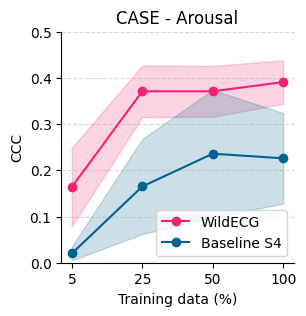

In [4]:
dataset = "WESAD"
label = ""
files1 = [
    f"{dataset}_sa0.05_scratch_ecg_{label}",
    f"{dataset}_sa0.25_scratch_ecg_{label}",
    f"{dataset}_sa0.5_scratch_ecg_{label}",
    f"{dataset}_sa_scratch_ecg_{label}"
]
files2 = [
    f"{dataset}_sa0.05_init_ecg_{label}",
    f"{dataset}_sa0.25_init_ecg_{label}",
    f"{dataset}_sa0.5_init_ecg_{label}",
    f"{dataset}_sa_init_ecg_{label}"
]
files3 = [
    f"{dataset}_sa0.05_frozen_ecg_{label}",
    f"{dataset}_sa0.25_frozen_ecg_{label}",
    f"{dataset}_sa0.5_frozen_ecg_{label}",
    f"{dataset}_sa_frozen_ecg_{label}"
]

plot_results(files1, files2, files3, metric="CCC:", std=True)

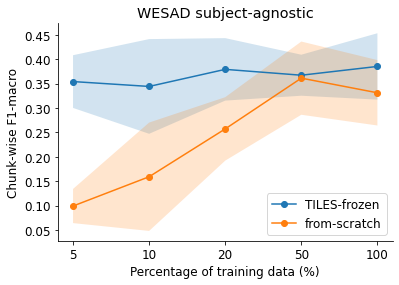

In [89]:
dataset = "WESAD"
file_list_1 = [f"{dataset}_frozen_005", f"{dataset}_frozen_010", f"{dataset}_frozen_020", f"{dataset}_frozen_050", f"{dataset}_frozen"]
file_list_2 = [f"{dataset}_scratch_005", f"{dataset}_scratch_010", f"{dataset}_scratch_020", f"{dataset}_scratch_050", f"{dataset}_scratch"]

plot_results(file_list_1, file_list_2, metric='Chunk-wise F1-macro')